In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class TimeSeriesDataset(Dataset):
    
    def __init__(self, data_path, augment=False):
        data = torch.load(data_path, weights_only=False)
        self.samples = data['samples']
        self.labels = data['labels'].long() if 'labels' in data else None
        
        # Reshape and scale samples
        num_samples, num_channels, num_time_steps = self.samples.shape
        samples_reshaped = self.samples.reshape(num_samples, -1)
        
        scaler = StandardScaler()
        samples_scaled = scaler.fit_transform(samples_reshaped)
        
        self.samples = torch.tensor(
            samples_scaled.reshape(num_samples, num_channels, num_time_steps), 
            dtype=torch.float32
        )
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if self.augment:
            if torch.rand(1) > 0.5:
                noise = torch.randn_like(sample) * 0.05
                sample = sample + noise
            if torch.rand(1) > 0.5:
                sample = torch.flip(sample, [1])
        
        if self.labels is not None:
            return sample, self.labels[idx]
        return sample

# Define paths to data
har_train_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/train.pt', augment=True)
har_val_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/val.pt')
har_test_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/test.pt')

gesture_train_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/train.pt', augment=True)
gesture_val_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/val.pt')
gesture_test_data = TimeSeriesDataset('/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/test.pt')

# Create data loaders
har_train_loader = DataLoader(har_train_data, batch_size=32, shuffle=True)
har_val_loader = DataLoader(har_val_data, batch_size=32)
har_test_loader = DataLoader(har_test_data, batch_size=32)

gesture_train_loader = DataLoader(gesture_train_data, batch_size=32, shuffle=True)
gesture_val_loader = DataLoader(gesture_val_data, batch_size=32)
gesture_test_loader = DataLoader(gesture_test_data, batch_size=32)


Model Blocks for CNN, LSTM, Residual, and Transformer

In [111]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
    
    def forward(self, x):
        return self.conv(x)

class LSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.norm = nn.LayerNorm(hidden_size * 2)
    
    def forward(self, x):
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        return self.norm(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return self.relu(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead=1, dim_feedforward=256):  # Set nhead=1 to avoid the divisibility issue
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
    
    def forward(self, x):
        x = x.transpose(1, 2)
        att_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + att_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x.transpose(1, 2)


Ensemble Model

In [112]:
class EnsembleModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        
        self.cnn = nn.Sequential(
            CNNBlock(input_dim, hidden_dim),
            CNNBlock(hidden_dim, hidden_dim*2),
            ResidualBlock(hidden_dim*2)
        )
        
        self.lstm = LSTMBlock(input_dim, hidden_dim)
        
        self.transformer = TransformerBlock(input_dim, nhead=1)
        
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim*2 + hidden_dim*2 + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        cnn_out = torch.mean(self.cnn(x), dim=2)
        lstm_out = torch.mean(self.lstm(x), dim=1)
        trans_out = torch.mean(self.transformer(x), dim=2)
        
        concat = torch.cat([cnn_out, lstm_out, trans_out], dim=1)
        return self.fusion(concat)


Training and Validation Functions

In [113]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for samples, labels in loader:
        samples, labels = samples.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(samples)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)
            outputs = model(samples)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(loader), 100 * correct / total

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



Train and Fine-Tune the Model

Pre-training on HAR dataset...


/home/sk/Downloads/業務体験課題/assignment-main/Chief-AI-Engineer/time-series-ssl/.env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100:
Train Loss: 1.1048, Train Accuracy: 62.73%
Validation Loss: 0.6754, Validation Accuracy: 82.60%
Epoch 2/100:
Train Loss: 0.6242, Train Accuracy: 79.36%
Validation Loss: 0.3862, Validation Accuracy: 90.21%
Epoch 3/100:
Train Loss: 0.4240, Train Accuracy: 87.23%
Validation Loss: 0.2539, Validation Accuracy: 93.27%
Epoch 4/100:
Train Loss: 0.3258, Train Accuracy: 89.76%
Validation Loss: 0.2361, Validation Accuracy: 91.84%
Epoch 5/100:
Train Loss: 0.2594, Train Accuracy: 91.50%
Validation Loss: 0.1696, Validation Accuracy: 94.90%
Epoch 6/100:
Train Loss: 0.2393, Train Accuracy: 91.91%
Validation Loss: 0.1628, Validation Accuracy: 94.02%
Epoch 7/100:
Train Loss: 0.2234, Train Accuracy: 92.38%
Validation Loss: 0.1542, Validation Accuracy: 93.81%
Epoch 8/100:
Train Loss: 0.1924, Train Accuracy: 93.57%
Validation Loss: 0.1619, Validation Accuracy: 93.54%
Epoch 9/100:
Train Loss: 0.1892, Train Accuracy: 93.35%
Validation Loss: 0.1527, Validation Accuracy: 94.29%
Epoch 10/100:
Train

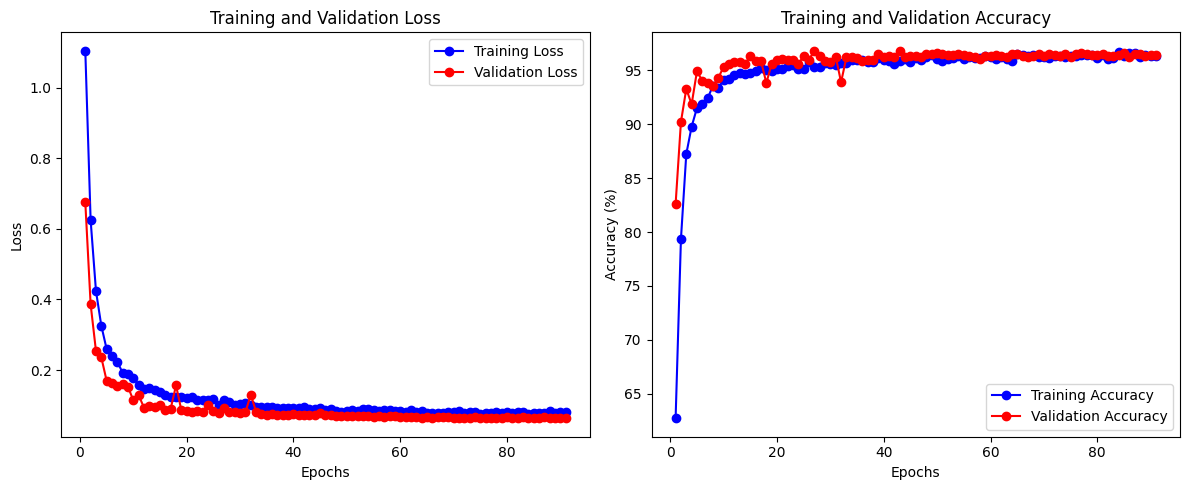

In [114]:
# Initialize model, criterion, and optimizer for HAR pre-training
har_model = EnsembleModel(input_dim=3, hidden_dim=64, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(har_model.parameters(), lr=0.0001)

# Function to train and validate for HAR pre-training
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, n_epochs, patience, model_name="model"):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
        
        scheduler.step(val_loss)
        
        # Early stopping and saving best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    return history

# Train HAR model and save the best model
print("Pre-training on HAR dataset...")
har_history = train_and_evaluate(har_model, har_train_loader, har_val_loader, criterion, optimizer, device,n_epochs=100,patience=10, model_name="har")

# Plot HAR pre-training history
plot_training_history(har_history)


Result Before Fine Tuning

Evaluating pre-trained HAR model on HAR test set (before fine-tuning)...
HAR (pre-finetune) - Loss: 0.5394, Accuracy: 89.96%
Evaluating pre-trained HAR model on Gesture test set (before fine-tuning)...
Gesture (pre-finetune) - Loss: 11.7970, Accuracy: 12.50%


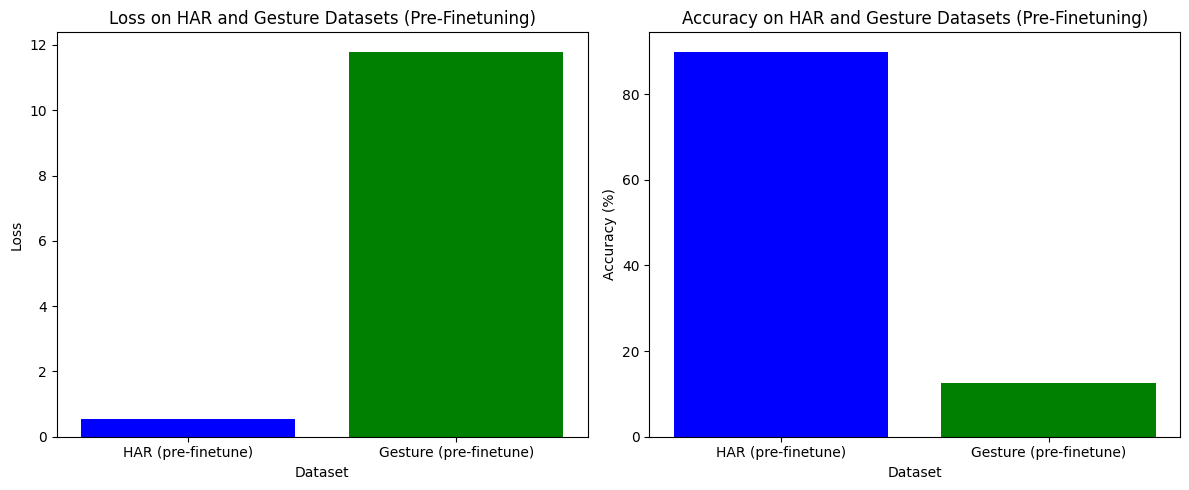

In [118]:
# Evaluate pre-trained HAR model on HAR test set
print("Evaluating pre-trained HAR model on HAR test set (before fine-tuning)...")
har_pre_finetune_loss, har_pre_finetune_accuracy = evaluate_on_dataset(har_model, har_test_loader, criterion, device, dataset_name="HAR (pre-finetune)")

# Temporarily adjust the output layer for 8 classes before evaluating on Gesture test set
original_fusion_layer = har_model.fusion[3]
har_model.fusion[3] = nn.Linear(original_fusion_layer.in_features, 8).to(device)
nn.init.xavier_uniform_(har_model.fusion[3].weight)
nn.init.zeros_(har_model.fusion[3].bias)

# Evaluate pre-trained HAR model on Gesture test set (before fine-tuning)
print("Evaluating pre-trained HAR model on Gesture test set (before fine-tuning)...")
gesture_pre_finetune_loss, gesture_pre_finetune_accuracy = evaluate_on_dataset(har_model, gesture_test_loader, criterion, device, dataset_name="Gesture (pre-finetune)")

# Restore the original output layer for further use
har_model.fusion[3] = original_fusion_layer.to(device)

# Plotting pre-finetuning results
def plot_pre_finetuning_results(har_loss, har_accuracy, gesture_loss, gesture_accuracy):
    labels = ['HAR (pre-finetune)', 'Gesture (pre-finetune)']
    losses = [har_loss, gesture_loss]
    accuracies = [har_accuracy, gesture_accuracy]
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(labels, losses, color=['blue', 'green'])
    plt.title('Loss on HAR and Gesture Datasets (Pre-Finetuning)')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.bar(labels, accuracies, color=['blue', 'green'])
    plt.title('Accuracy on HAR and Gesture Datasets (Pre-Finetuning)')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Plot results before fine-tuning
plot_pre_finetuning_results(har_pre_finetune_loss, har_pre_finetune_accuracy, gesture_pre_finetune_loss, gesture_pre_finetune_accuracy)


Fine tune

Fine-tuning on Gesture dataset...
Epoch 1/150:
Train Loss: 4.7589, Train Accuracy: 10.94%
Validation Loss: 2.8836, Validation Accuracy: 15.00%
Epoch 2/150:
Train Loss: 3.7366, Train Accuracy: 13.44%
Validation Loss: 2.4850, Validation Accuracy: 20.83%
Epoch 3/150:
Train Loss: 3.3631, Train Accuracy: 16.56%
Validation Loss: 2.2583, Validation Accuracy: 21.67%
Epoch 4/150:
Train Loss: 2.9773, Train Accuracy: 18.75%
Validation Loss: 2.0429, Validation Accuracy: 23.33%
Epoch 5/150:
Train Loss: 2.6436, Train Accuracy: 21.25%
Validation Loss: 1.8742, Validation Accuracy: 29.17%
Epoch 6/150:
Train Loss: 2.5610, Train Accuracy: 19.38%
Validation Loss: 1.7745, Validation Accuracy: 30.83%
Epoch 7/150:
Train Loss: 2.3194, Train Accuracy: 24.69%
Validation Loss: 1.7279, Validation Accuracy: 40.00%
Epoch 8/150:
Train Loss: 2.2359, Train Accuracy: 23.75%
Validation Loss: 1.6799, Validation Accuracy: 45.83%
Epoch 9/150:
Train Loss: 2.1163, Train Accuracy: 27.50%
Validation Loss: 1.6626, Validation Ac

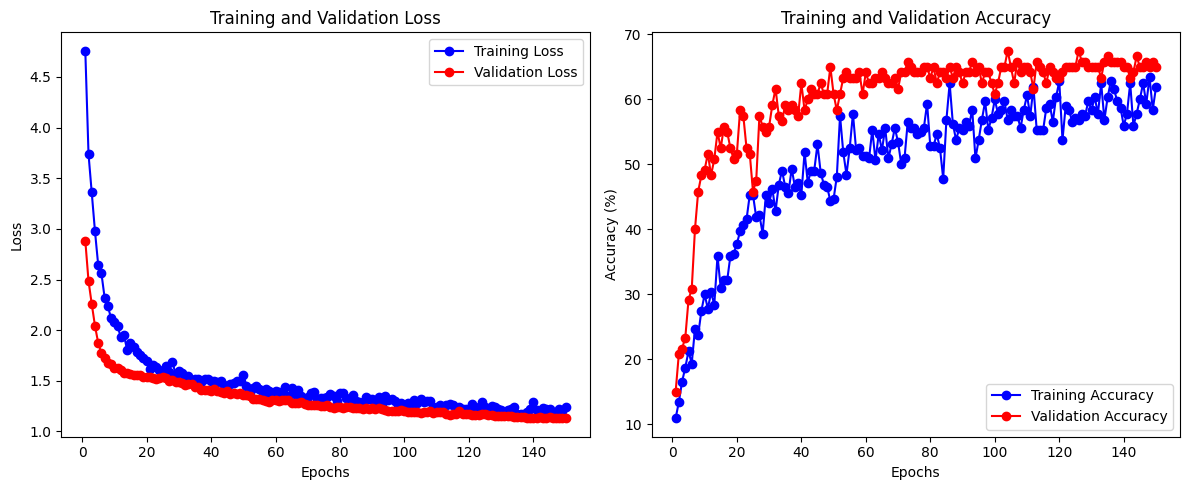

In [121]:
# Initialize model for Gesture fine-tuning
gesture_model = EnsembleModel(input_dim=3, hidden_dim=64, num_classes=8).to(device)

# Load pre-trained model (HAR) and adjust the state_dict
har_model_state_dict = torch.load('har_best_model.pth', map_location=device, weights_only=False)

# Remove the mismatched keys (output layer)
har_model_state_dict = {k: v for k, v in har_model_state_dict.items() if 'fusion.3' not in k}

# Load the state_dict into the Gesture model
gesture_model.load_state_dict(har_model_state_dict, strict=False)

# Manually adjust the output layer for Gesture dataset (8 classes)
gesture_model.fusion[3] = nn.Linear(gesture_model.fusion[3].in_features, 8)

# Optionally, reinitialize the output layer weights if you want
nn.init.xavier_uniform_(gesture_model.fusion[3].weight)
nn.init.zeros_(gesture_model.fusion[3].bias)

# Proceed with fine-tuning on Gesture dataset
optimizer = optim.Adam(gesture_model.parameters(), lr=0.0001)

print("Fine-tuning on Gesture dataset...")
gesture_history = train_and_evaluate(gesture_model, gesture_train_loader, gesture_val_loader, criterion, optimizer, device,n_epochs=150,patience =10, model_name="gesture")

# Plot Gesture fine-tuning history
plot_training_history(gesture_history)



Evaluating on HAR dataset...
HAR - Loss: 0.5394, Accuracy: 89.96%
Evaluating on Gesture dataset...
Gesture - Loss: 1.1296, Accuracy: 65.00%


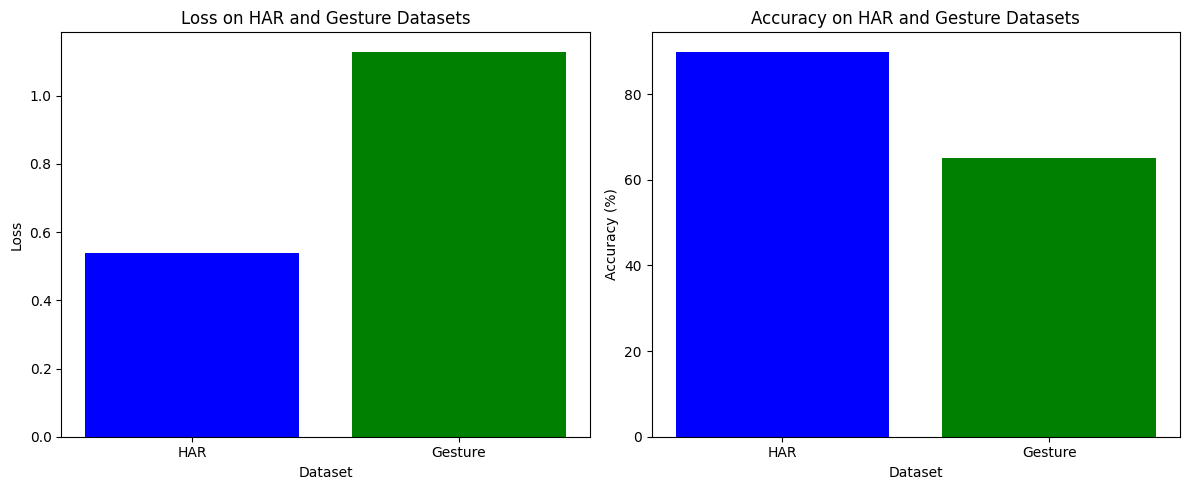

In [122]:
# Evaluate on HAR dataset
def evaluate_on_dataset(model, loader, criterion, device, dataset_name="Dataset"):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device).long()
            outputs = model(samples)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    print(f'{dataset_name} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return avg_loss, accuracy

# Evaluate on HAR dataset
print("Evaluating on HAR dataset...")
har_loss, har_accuracy = evaluate_on_dataset(har_model, har_test_loader, criterion, device, dataset_name="HAR")

# Evaluate on Gesture dataset
print("Evaluating on Gesture dataset...")
gesture_loss, gesture_accuracy = evaluate_on_dataset(gesture_model, gesture_test_loader, criterion, device, dataset_name="Gesture")

# Plotting the results
def plot_evaluation_results(har_loss, har_accuracy, gesture_loss, gesture_accuracy):
    labels = ['HAR', 'Gesture']
    losses = [har_loss, gesture_loss]
    accuracies = [har_accuracy, gesture_accuracy]
    
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(labels, losses, color=['blue', 'green'])
    plt.title('Loss on HAR and Gesture Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.bar(labels, accuracies, color=['blue', 'green'])
    plt.title('Accuracy on HAR and Gesture Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Plotting the results
plot_evaluation_results(har_loss, har_accuracy, gesture_loss, gesture_accuracy)

1st:
Evaluating on HAR dataset...
HAR - Loss: 0.5719, Accuracy: 89.85%
Evaluating on Gesture dataset...
Gesture - Loss: 1.2498, Accuracy: 67.50%

2nd:
Evaluating on HAR dataset...
HAR - Loss: 0.5394, Accuracy: 89.96%
Evaluating on Gesture dataset...
Gesture - Loss: 1.0656, Accuracy: 65.83%

3rd:
Evaluating on HAR dataset...
HAR - Loss: 0.5394, Accuracy: 89.96%
Evaluating on Gesture dataset...
Gesture - Loss: 1.1296, Accuracy: 65.00%